In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cmcrameri.cm as cm
import utils.load_grid as lg

from proteus.utils.constants import R_earth, M_earth

%matplotlib widget

In [2]:
pgrid_dir = "data/output/l9859d_grid1"
cases = lg.get_cases(pgrid_dir)
ncases = len(cases)

In [13]:
# Helpfiles
helps, hvars = lg.load_helpfiles(cases)

# Case numbers
cnums = ["%d"%int(s.split("_")[-1]) for s in cases]

# Configuration variables
# cvars = lg.load_cvars(cases)

print("Done")

Helpfiles: 100%|██████████| 48/48 [00:00<00:00, 81.91it/s]


Done


In [4]:
# observations (mass, radius) (value, +err, -err)
obs = {
    "Demangeon+21": [[1.94, 0.28, 0.28], [1.521, 0.119, 0.098]],
    "Rajpaul+24":   [[2.14, 0.25, 0.29], []],
    "Luque+22":     [[2.31, 0.46, 0.45], [1.58, 0.08, 0.08 ]],
    "Cloutier+19":  [[2.31, 0.46, 0.45], [1.57, 0.14, 0.14]],
}

In [5]:
plt.close("all")

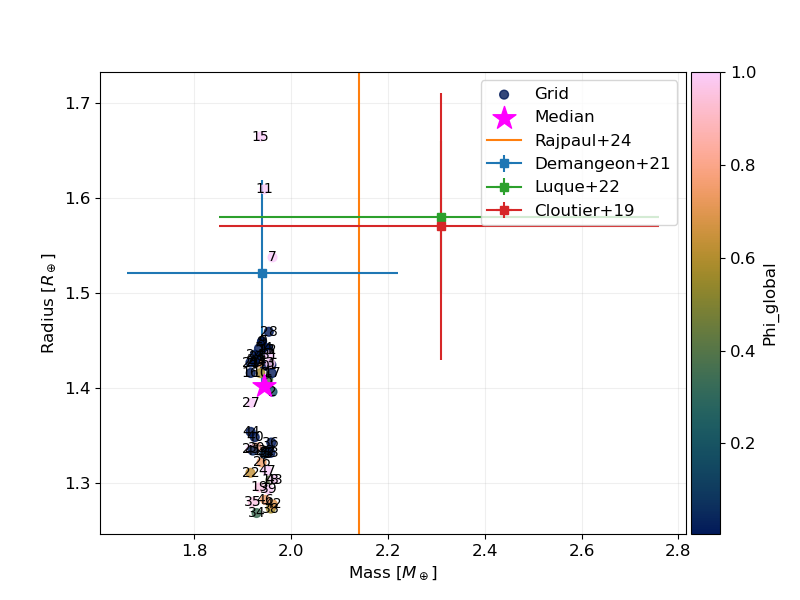

In [24]:
# parameters
z_key       = "Phi_global"
z_scale     = "linear"
jitter      = 0.05
cmap        = cm.batlow
plt_cnums   = True

# Grid data
grd_x = lg.access_hvars(hvars,"M_tot",-1) / M_earth
grd_y = (lg.access_hvars(hvars,"z_obs",-1) + lg.access_hvars(hvars,"R_int",-1)) / R_earth
grd_z = lg.access_hvars(hvars,z_key,-1)

# Spread x
grd_x = np.random.random_sample(len(grd_x)) * jitter + grd_x - jitter/2

if z_scale == 'log':
    norm = mpl.colors.SymLogNorm(vmin=np.amin(grd_z), vmax=np.amax(grd_z), clip=True, linthresh=0.1)
else:
    norm = mpl.colors.Normalize(vmin=np.amin(grd_z), vmax=np.amax(grd_z), clip=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# make figure
fig,ax = plt.subplots(1,1, figsize=(8,6))
ax.set_xlabel(r"Mass [$M_\oplus$]")
ax.set_ylabel(r"Radius [$R_\oplus$]")

# plot grid
ax.scatter(grd_x, grd_y, c=grd_z, label="Grid",
            cmap=cmap, norm=norm, alpha=0.8, zorder=6, s=40, marker='o')

# case numbers
if plt_cnums:
    for i in range(len(cnums)):
        x, y = grd_x[i], grd_y[i]
        txt = cnums[i]
        ax.text(x,y,txt,
                    fontsize=10,
                    verticalalignment='center', horizontalalignment='center', zorder=8)


# grid median
ref_y = np.median(grd_y)
ref_x = np.median(grd_x)
ax.scatter(ref_x, ref_y, c='magenta', label="Median", s=300, marker='*', zorder=10)

# colorbar
cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
fig.colorbar(sm, cax=cax, orientation='vertical').set_label(z_key)

# Plot observations
for k in obs.keys():
    _m = obs[k][0]
    _r = obs[k][1]

    if len(_m)+len(_r) == 6:
        ax.errorbar(_m[0],_r[0],
                    xerr=[[_m[1]],[_m[2]]], yerr=[[_r[1]],[_r[2]]],
                    marker='s', label=k, zorder=4)

    elif len(_m) == 3:
        c = ax.plot(_m[0],ref_y)[0].get_color() # dummy colour
        ax.axvline(x=_m[0], label=k, c=c)

    elif len(_r) == 3:
        c = ax.plot(ref_x,_r[0],)[0].get_color() # dummy colour
        ax.axhline(y=_r[0], label=k, c=c)

ax.grid(zorder=0, alpha=0.2)
ax.legend()
plt.show()